In [24]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import warnings

warnings.filterwarnings(
    "ignore",
    message="plotting functions contained within `_documentation_utils` are intended for nemos's documentation.",
    category=UserWarning,
)

warnings.filterwarnings(
    "ignore",
    message="Ignoring cached namespace 'core'",
    category=UserWarning,
)

warnings.filterwarnings(
    "ignore",
    message=(
        "invalid value encountered in div "
    ),
    category=RuntimeWarning,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


:::{admonition} Download
:class: important render-all

This notebook can be downloaded as **{nb-download}`place_cells-users.ipynb`**. See the button at the top right to download as markdown or pdf.

:::
# Model and feature selection with scikit-learn
This notebook has had all its explanatory text removed and has not been run.
 It is intended to be downloaded and run locally (or on the provided binder)
 while listening to the presenter's explanation. In order to see the fully
 rendered of this notebook, go [here](../../full/day2/place_cells.md)

Data for this notebook comes from recordings in the mouse hippocampus while the mouse runs on a linear track, which we [explored yesterday](../day1/phase_precession-users.md).


## Learning objectives

- Review how to use pynapple to analyze neuronal tuning
- Learn how to combine NeMoS basis objects
- Learn how to use NeMoS objects with [scikit-learn](https://scikit-learn.org/) for cross-validation
- Learn how to use NeMoS objects with scikit-learn [pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
- Learn how to use cross-validation to perform model and feature selection

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pynapple as nap

import nemos as nmo

# some helper plotting functions
from nemos import _documentation_utils as doc_plots
import workshop_utils

# configure plots some
plt.style.use(nmo.styles.plot_style)

import workshop_utils

from sklearn import model_selection
from sklearn import pipeline

# shut down jax to numpy conversion warning
nap.nap_config.suppress_conversion_warnings = True

# during development, set this to a lower number so everything runs faster. 
cv_folds = 5

## Pynapple

- Load the data using pynapple.

In [26]:
path = workshop_utils.fetch_data("Achilles_10252013_EEG.nwb")
data = nap.load_file(path)
data

/Users/jorge/Princeton Dropbox/Jorge Yanar/research/workshops/ccn-software-jan-2025/.venv/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/jorge/Princeton Dropbox/Jorge Yanar/research/workshops/ccn-software-jan-2025/.venv/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Achilles_10252013_EEG
┍━━━━━━━━━━━━━┯━━━━━━━━━━━━━┑
│ Keys        │ Type        │
┝━━━━━━━━━━━━━┿━━━━━━━━━━━━━┥
│ units       │ TsGroup     │
│ rem         │ IntervalSet │
│ nrem        │ IntervalSet │
│ forward_ep  │ IntervalSet │
│ eeg         │ TsdFrame    │
│ theta_phase │ Tsd         │
│ position    │ Tsd         │
┕━━━━━━━━━━━━━┷━━━━━━━━━━━━━┙

- Extract the spike times and mouse position.

In [27]:
spikes = data["units"]
position = data["position"]

- Restrict data to when animal was traversing the linear track.

In [28]:
position = position.restrict(data["forward_ep"])
spikes = spikes.restrict(data["forward_ep"])

- Restrict neurons to only excitatory neurons, discarding neurons with a low-firing rate.

In [29]:
spikes = spikes.getby_category("cell_type")["pE"]
spikes = spikes.getby_threshold("rate", 0.3)

### Place fields


- Visualize the *place fields*: neuronal firing rate as a function of position.

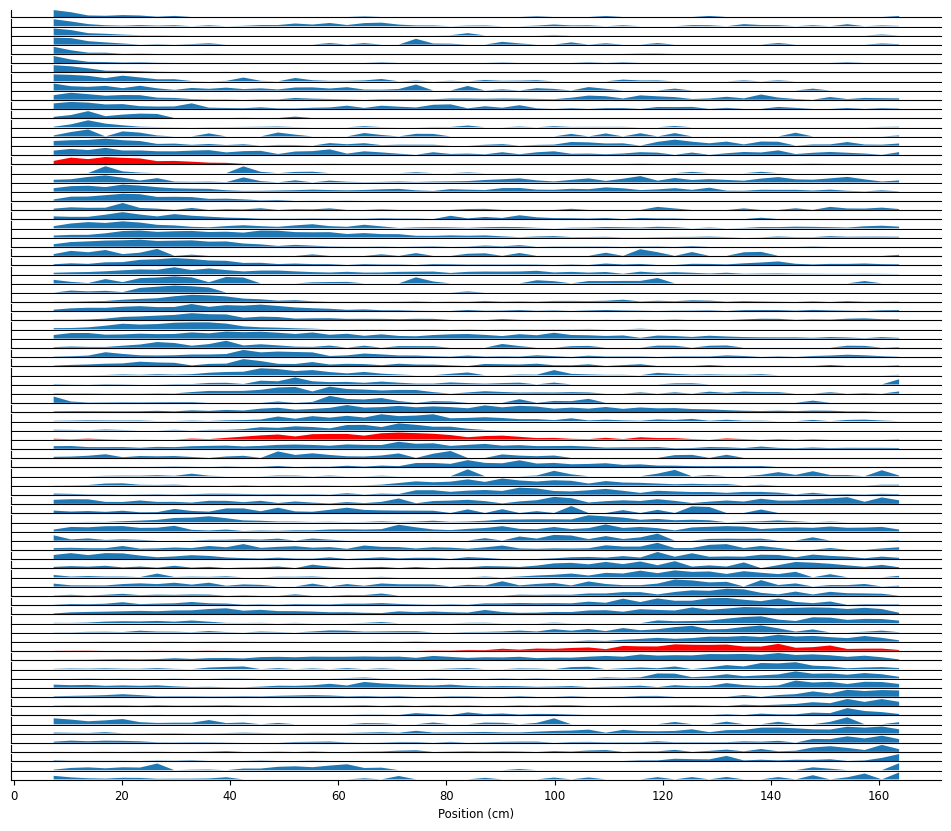

In [30]:
place_fields = nap.compute_1d_tuning_curves(spikes, position, 50, position.time_support)
workshop_utils.plot_place_fields(place_fields)

- For speed, we're only going to investigate the three neurons highlighted above.
- Bin spikes to counts at 100 Hz.
- Interpolate position to match spike resolution.

In [31]:
neurons = [82, 92, 220]
place_fields = place_fields[neurons]
spikes = spikes[neurons]
bin_size = .01
count = spikes.count(bin_size, ep=position.time_support)
position = position.interpolate(count, ep=count.time_support)
print(count.shape)
print(position.shape)

(19237, 3)
(19237,)


### Speed modulation


- Compute animal's speed for each epoch.

In [32]:
speed = []
# Analyzing each epoch separately avoids edge effects.
for s, e in position.time_support.values: 
    pos_ep = position.get(s, e)
    # Absolute difference of two consecutive points
    speed_ep = np.abs(np.diff(pos_ep)) 
    # Padding the edge so that the size is the same as the position/spike counts
    speed_ep = np.pad(speed_ep, [0, 1], mode="edge") 
    # Converting to cm/s 
    speed_ep = speed_ep * position.rate
    speed.append(speed_ep)

speed = nap.Tsd(t=position.t, d=np.hstack(speed), time_support=position.time_support)
print(speed.shape)

(19237,)


- Compute the tuning curve with pynapple's [`compute_1d_tuning_curves`](https://pynapple.org/generated/pynapple.process.tuning_curves.html#pynapple.process.tuning_curves.compute_1d_tuning_curves)

In [33]:
tc_speed = nap.compute_1d_tuning_curves(spikes, speed, 30)

/Users/jorge/Princeton Dropbox/Jorge Yanar/research/workshops/ccn-software-jan-2025/.venv/lib/python3.11/site-packages/pynapple/process/tuning_curves.py:186: RuntimeWarning: invalid value encountered in divide
  count = count / occupancy


In [34]:
# compute tuning curve here
#tc_speed = 

- Visualize the position and speed tuning for these neurons.

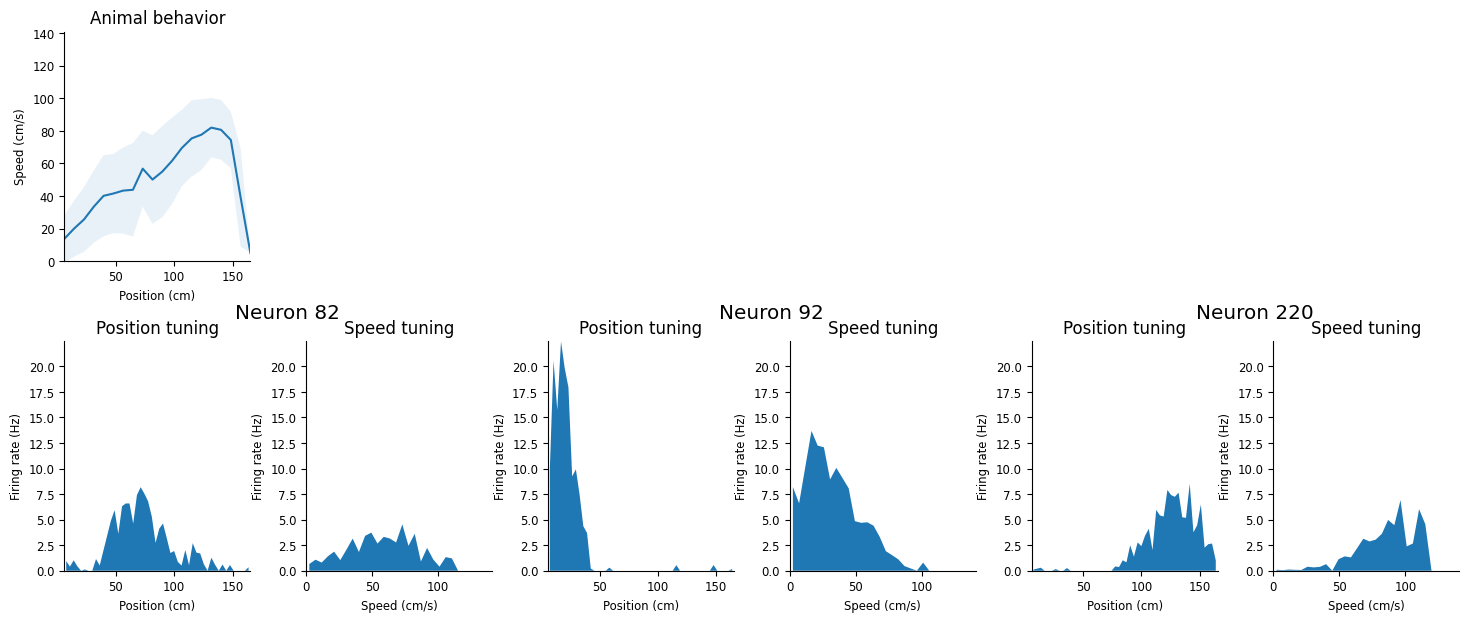

In [35]:
fig = workshop_utils.plot_position_speed(position, speed, place_fields, tc_speed, neurons);

These neurons all show both position and speed tuning, and we see that the animal's speed and position are highly correlated. We're going to build a GLM to predict neuronal firing rate -- which variable should we use? Is the speed tuning just epiphenomenal?
## NeMoS
### Basis evaluation


- Create a separate basis object for each model input.
- Visualize the basis objects.

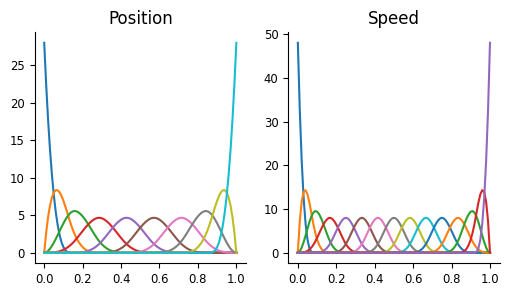

In [36]:
position_basis = nmo.basis.MSplineEval(n_basis_funcs=10)
speed_basis = nmo.basis.MSplineEval(n_basis_funcs=15)
workshop_utils.plot_pos_speed_bases(position_basis, speed_basis)

- Combine the two basis objects into a single "additive basis"

In [37]:
# enter code here
basis = position_basis + speed_basis

- Create the design matrix!
- Notice that, since we passed the basis pynapple objects, we got one back, preserving the time stamps.
- `X` has the same number of time points as our input position and speed, but 25 columns. The columns come from  `n_basis_funcs` from each basis (10 for position, 15 for speed).

In [38]:
X = basis.compute_features(position, speed)

### Model learning


- Initialize `PopulationGLM`
- Use the "LBFGS" solver and pass `{"tol": 1e-12}` to `solver_kwargs`.
- Fit the data, passing the design matrix and spike counts to the glm object.

In [39]:
# initialize 
glm = nmo.glm.PopulationGLM(solver_name='LBFGS', solver_kwargs={'tol': 1e-12})

# and fit
glm.fit(X, count)

PopulationGLM(
    observation_model=PoissonObservations(inverse_link_function=exp),
    regularizer=UnRegularized(),
    solver_name='LBFGS',
    solver_kwargs={'tol': 1e-12}
)

### Prediction


- Use `predict` to check whether our GLM has captured each neuron's speed and position tuning.
- Remember to convert the predicted firing rate to spikes per second!

In [40]:
# predict the model's firing rate
predicted_rate = glm.predict(X) / bin_size

# same shape as the counts we were trying to predict
print(predicted_rate.shape, count.shape)

# compute the position and speed tuning curves using the predicted firing rate.
glm_pf = nap.compute_1d_tuning_curves_continuous(predicted_rate, position, nb_bins=30)
glm_speed = nap.compute_1d_tuning_curves_continuous(predicted_rate, speed, nb_bins=30)

(19237, 3) (19237, 3)


/Users/jorge/Princeton Dropbox/Jorge Yanar/research/workshops/ccn-software-jan-2025/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jorge/Princeton Dropbox/Jorge Yanar/research/workshops/ccn-software-jan-2025/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


- Compare model and data tuning curves together. The model did a pretty good job!

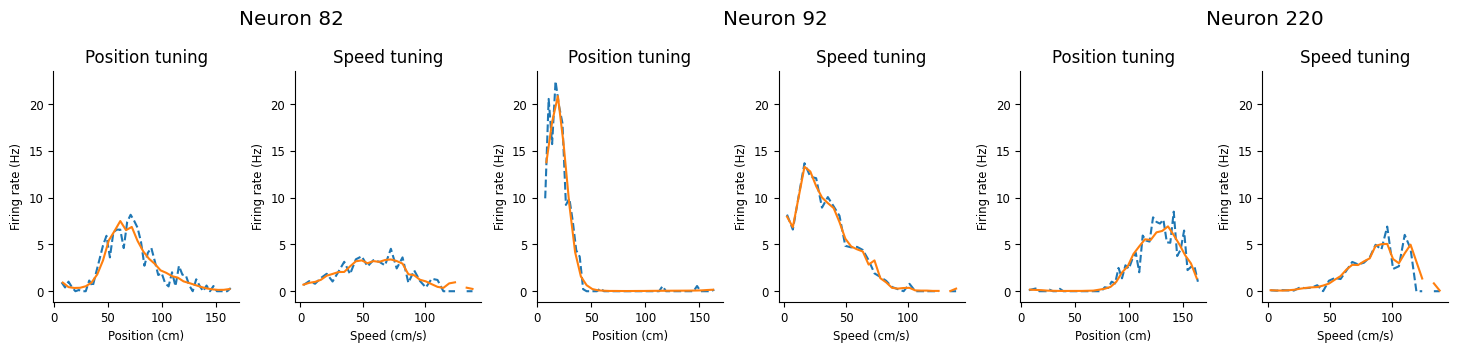

In [41]:
workshop_utils.plot_position_speed_tuning(place_fields, tc_speed, glm_pf, glm_speed);

To make our lives easier, let's create a helper function that wraps the above
lines, because we're going to be visualizing our model predictions a lot.

In [44]:
def visualize_model_predictions(glm, X):
    # predict the model's firing rate
    predicted_rate = glm.predict(X) / bin_size
    
    # same shape as the counts we were trying to predict
    print(predicted_rate.shape, count.shape)
    
    # compute the position and speed tuning curves using the predicted firing rate.
    glm_pf = nap.compute_1d_tuning_curves_continuous(predicted_rate, position, nb_bins=30)
    glm_speed = nap.compute_1d_tuning_curves_continuous(predicted_rate, speed, nb_bins=30)
    workshop_utils.plot_position_speed_tuning(place_fields, tc_speed, glm_pf, glm_speed);

## Scikit-learn
### How to know when to regularize?


- How do we decide when to use regularization?
- Cross-validation allows you to fairly compare different models on the same dataset.
- NeMoS makes use of [scikit-learn](https://scikit-learn.org/), the standard machine learning library in python.
- Define [parameter grid](https://scikit-learn.org/stable/modules/grid_search.html#grid-search) to search over.
- Anything not specified in grid will be kept constant.

In [47]:
param_grid = {
    'regularizer': ["UnRegularized", "Ridge"],
}

- Initialize scikit-learn's [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) object.

In [52]:
cv = model_selection.GridSearchCV(glm, param_grid, cv=cv_folds)
cv

GridSearchCV(cv=5,
             estimator=PopulationGLM(
    observation_model=PoissonObservations(inverse_link_function=exp),
    regularizer=UnRegularized(),
    solver_name='LBFGS',
    solver_kwargs={'tol': 1e-12}
),
             param_grid={'regularizer': ['UnRegularized', 'Ridge']})

- We interact with this in a very similar way to the glm object.
- In particular, call `fit` with same arguments:

In [53]:
cv.fit(X, count)

/Users/jorge/Princeton Dropbox/Jorge Yanar/research/workshops/ccn-software-jan-2025/.venv/lib/python3.11/site-packages/nemos/base_regressor.py:193: UserWarning: Caution: regularizer strength has not been set. Defaulting to 1.0. Please see the documentation for best practices in setting regularization strength.
  warnings.warn(
/Users/jorge/Princeton Dropbox/Jorge Yanar/research/workshops/ccn-software-jan-2025/.venv/lib/python3.11/site-packages/nemos/base_regressor.py:193: UserWarning: Caution: regularizer strength has not been set. Defaulting to 1.0. Please see the documentation for best practices in setting regularization strength.
  warnings.warn(
/Users/jorge/Princeton Dropbox/Jorge Yanar/research/workshops/ccn-software-jan-2025/.venv/lib/python3.11/site-packages/nemos/base_regressor.py:193: UserWarning: Caution: regularizer strength has not been set. Defaulting to 1.0. Please see the documentation for best practices in setting regularization strength.
  warnings.warn(
/Users/jorge/

GridSearchCV(cv=5,
             estimator=PopulationGLM(
    observation_model=PoissonObservations(inverse_link_function=exp),
    regularizer=UnRegularized(),
    solver_name='LBFGS',
    solver_kwargs={'tol': 1e-12}
),
             param_grid={'regularizer': ['UnRegularized', 'Ridge']})

- We got a warning because we didn't specify the regularizer strength, so we just fell back on default value.
- Let's investigate results:

In [54]:
cv.cv_results_

{'mean_fit_time': array([1.53619266, 0.97446375]),
 'std_fit_time': array([0.69715014, 0.01169491]),
 'mean_score_time': array([0.27406483, 0.00198269]),
 'std_score_time': array([0.33341342, 0.00035078]),
 'param_regularizer': masked_array(data=['UnRegularized', 'Ridge'],
              mask=[False, False],
        fill_value=np.str_('?'),
             dtype=object),
 'params': [{'regularizer': 'UnRegularized'}, {'regularizer': 'Ridge'}],
 'split0_test_score': array([-0.1131183 , -0.13712785]),
 'split1_test_score': array([-0.10424681, -0.12844072]),
 'split2_test_score': array([-0.1386172 , -0.17322585]),
 'split3_test_score': array([-0.11733417, -0.13869132]),
 'split4_test_score': array([-0.11519353, -0.13128021]),
 'mean_test_score': array([-0.117702  , -0.14175319]),
 'std_test_score': array([0.01136597, 0.0161753 ]),
 'rank_test_score': array([1, 2], dtype=int32)}

:::{note}
Could (and generally, should!) investigate `regularizer_strength`, but we're skipping for complexity. To do this properly, use a slightly different syntax for `param_grid` (list of dictionaries, instead of single dictionary)

```python
param_grid = [
{"regularizer": [nmo.regularizer.UnRegularized()]},
{"regularizer": [nmo.regularizer.Ridge()],
"regularizer_strength": [1e-6, 1e-3, 1]}
]
```
:::
### Select basis


- You can (and should) do something similar to determine how many basis functions you need for each input.
- NeMoS basis objects are not scikit-learn-compatible right out of the box.
- But we have provided a simple method to make them so:

In [55]:
position_basis = nmo.basis.MSplineEval(10).to_transformer()

In [56]:
position_basis

Transformer(MSplineEval(n_basis_funcs=10, order=4))

- This gives the basis object the `transform` method, which is equivalent to `compute_features`.
- However, transformers have some limits:

In [ ]:
position_basis.transfor

- Transformers only accept 2d inputs, whereas nemos basis objects can accept inputs of any dimensionality.
- In order to tell nemos how to reshape the 2d matrix that is the input of `transform` to whatever the basis accepts, you need to call `set_input_shape`:

In [57]:
position_basis.set_input_shape(1)

Transformer(MSplineEval(n_basis_funcs=10, order=4))

- Then you can call transform on the 2d input as expected.

In [58]:
position_basis.transform(np.expand_dims(position, 1))

Time (s)         0        1        2        3    4    ...
---------------  -------  -------  -------  ---  ---  -----
18193.603802655  0.16285  0.0063   5e-05    0.0  0.0  ...
18193.613802655  0.15956  0.0079   9e-05    0.0  0.0  ...
18193.623802655  0.1563   0.00947  0.00012  0.0  0.0  ...
18193.633802655  0.15111  0.01195  0.0002   0.0  0.0  ...
18193.643802655  0.1459   0.0144   0.0003   0.0  0.0  ...
18193.653802655  0.14197  0.01623  0.00039  0.0  0.0  ...
18193.663802655  0.13996  0.01716  0.00045  0.0  0.0  ...
...              ...      ...      ...      ...  ...  ...
20123.332682821  0.0      0.0      0.0      0.0  0.0  ...
20123.342682821  0.0      0.0      0.0      0.0  0.0  ...
20123.352682821  0.0      0.0      0.0      0.0  0.0  ...
20123.362682821  0.0      0.0      0.0      0.0  0.0  ...
20123.372682821  0.0      0.0      0.0      0.0  0.0  ...
20123.382682821  0.0      0.0      0.0      0.0  0.0  ...
20123.392682821  0.0      0.0      0.0      0.0  0.0  ...
dtype: float

- You can, equivalently, call `compute_features` *before* turning the basis into a transformer. Then we cache the shape for future use:

In [60]:
speed_basis = nmo.basis.MSplineEval(15).to_transformer().set_input_shape(1)

- Create a single TsdFrame to hold all our inputs:

In [61]:
transformer_input = nap.TsdFrame(
    t=position.t,
    d=np.stack([position.d, speed.d], 1),
    time_support=position.time_support,
    columns=["position", "speed"],
)

- Pass this input to our transformed additive basis:

In [62]:
basis = position_basis + speed_basis

In [63]:
basis.input_shape

[(), ()]

In [64]:
basis.transform(transformer_input)

Time (s)         0        1        2        3    4    ...
---------------  -------  -------  -------  ---  ---  -----
18193.603802655  0.16285  0.0063   5e-05    0.0  0.0  ...
18193.613802655  0.15956  0.0079   9e-05    0.0  0.0  ...
18193.623802655  0.1563   0.00947  0.00012  0.0  0.0  ...
18193.633802655  0.15111  0.01195  0.0002   0.0  0.0  ...
18193.643802655  0.1459   0.0144   0.0003   0.0  0.0  ...
18193.653802655  0.14197  0.01623  0.00039  0.0  0.0  ...
18193.663802655  0.13996  0.01716  0.00045  0.0  0.0  ...
...              ...      ...      ...      ...  ...  ...
20123.332682821  0.0      0.0      0.0      0.0  0.0  ...
20123.342682821  0.0      0.0      0.0      0.0  0.0  ...
20123.352682821  0.0      0.0      0.0      0.0  0.0  ...
20123.362682821  0.0      0.0      0.0      0.0  0.0  ...
20123.372682821  0.0      0.0      0.0      0.0  0.0  ...
20123.382682821  0.0      0.0      0.0      0.0  0.0  ...
20123.392682821  0.0      0.0      0.0      0.0  0.0  ...
dtype: float

### Pipelines


- If we want to cross-validate over the basis, we need more one more step: combining the basis and the GLM into a single scikit-learn estimator.
- [Pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to the rescue!

In [65]:
pipe = pipeline.Pipeline([
    ("basis", basis), ("glm", glm),
])

In [66]:
pipe

Pipeline(steps=[('basis',
                 Transformer(AdditiveBasis(
    basis1=MSplineEval(n_basis_funcs=10, order=4),
    basis2=MSplineEval(n_basis_funcs=15, order=4),
))),
                ('glm',
                 PopulationGLM(
    observation_model=PoissonObservations(inverse_link_function=exp),
    regularizer=UnRegularized(),
    solver_name='LBFGS',
    solver_kwargs={'tol': 1e-12}
))])

- Pipeline runs `basis.transform`, then passes that output to `glm`, so we can do everything in a single line:

In [67]:
pipe.fit(transformer_input, count)

Pipeline(steps=[('basis',
                 Transformer(AdditiveBasis(
    basis1=MSplineEval(n_basis_funcs=10, order=4),
    basis2=MSplineEval(n_basis_funcs=15, order=4),
))),
                ('glm',
                 PopulationGLM(
    observation_model=PoissonObservations(inverse_link_function=exp),
    regularizer=UnRegularized(),
    solver_name='LBFGS',
    solver_kwargs={'tol': 1e-12}
))])

- Visualize model predictions!

(19237, 3) (19237, 3)


/Users/jorge/Princeton Dropbox/Jorge Yanar/research/workshops/ccn-software-jan-2025/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jorge/Princeton Dropbox/Jorge Yanar/research/workshops/ccn-software-jan-2025/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


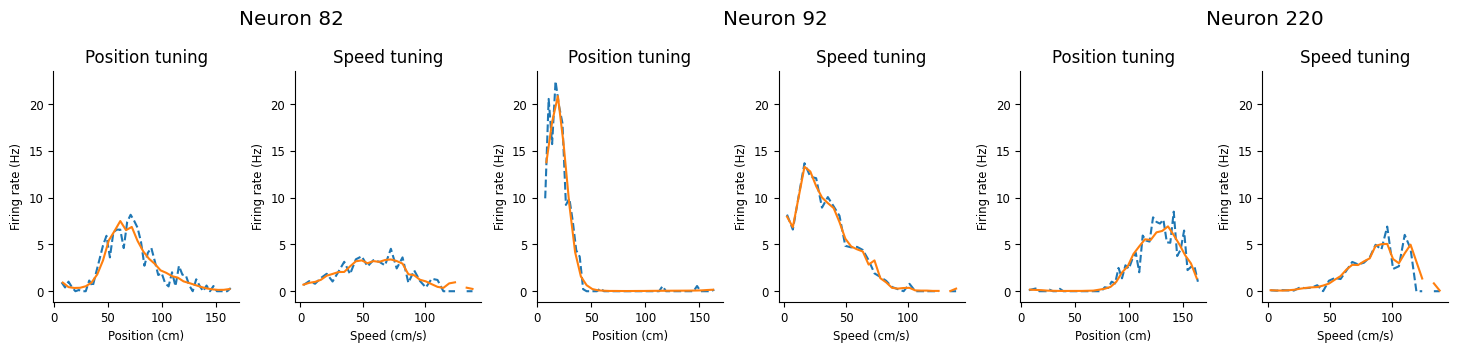

In [68]:
visualize_model_predictions(pipe, transformer_input)

### Cross-validating on the basis

Now that we have our pipeline estimator, we can cross-validate on any of its parameters!

In [69]:
pipe.steps

[('basis',
  Transformer(AdditiveBasis(
      basis1=MSplineEval(n_basis_funcs=10, order=4),
      basis2=MSplineEval(n_basis_funcs=15, order=4),
  ))),
 ('glm',
  PopulationGLM(
      observation_model=PoissonObservations(inverse_link_function=exp),
      regularizer=UnRegularized(),
      solver_name='LBFGS',
      solver_kwargs={'tol': 1e-12}
  ))]

Let's cross-validate on:
- The number of the basis functions of the position basis
- The functional form of the basis for speed

In [70]:
pipe["basis"].basis1.n_basis_funcs

10

- Construct `param_grid`, using `__` to stand in for `.`

In [71]:
param_grid = {
    "basis__basis1__n_basis_funcs": [5, 10, 20],
    "basis__basis2": [nmo.basis.MSplineEval(15).set_input_shape(1),
                      nmo.basis.BSplineEval(15).set_input_shape(1),
                      nmo.basis.RaisedCosineLinearEval(15).set_input_shape(11)]
}

- Cross-validate as before:

In [72]:
cv = model_selection.GridSearchCV(pipe, param_grid, cv=cv_folds)
cv.fit(transformer_input, count)

/Users/jorge/Princeton Dropbox/Jorge Yanar/research/workshops/ccn-software-jan-2025/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jorge/Princeton Dropbox/Jorge Yanar/research/workshops/ccn-software-jan-2025/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jorge/Princeton Dropbox/Jorge Yanar/research/workshops/ccn-software-jan-2025/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1389, in 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('basis',
                                        Transformer(AdditiveBasis(
    basis1=MSplineEval(n_basis_funcs=10, order=4),
    basis2=MSplineEval(n_basis_funcs=15, order=4),
))),
                                       ('glm',
                                        PopulationGLM(
    observation_model=PoissonObservations(inverse_link_function=exp),
    regularizer=UnRegularized(),
    solver_name='LBFGS',
    solver_kwargs={'tol': 1e-12}
))]),
             param_grid={'basis__basis1__n_basis_funcs': [5, 10, 20],
                         'basis__basis2': [MSplineEval(n_basis_funcs=15, order=4),
                                           BSplineEval(n_basis_funcs=15, order=4),
                                           RaisedCosineLinearEval(n_basis_funcs=15, width=2.0)]})

- Investigate results:

In [77]:
cv_df = pd.DataFrame(cv.cv_results_)
cv_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_basis__basis1__n_basis_funcs,param_basis__basis2,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.211111,0.322160,0.156177,0.182407,5,"(((MSplineEval(n_basis_funcs=15, order=4))))","{'basis__basis1__n_basis_funcs': 5, 'basis__ba...",-0.117449,-0.105565,-0.141796,-0.118578,-0.117132,-0.120104,0.011833,3
1,0.936124,0.003962,0.007487,0.000251,5,"(((BSplineEval(n_basis_funcs=15, order=4))))","{'basis__basis1__n_basis_funcs': 5, 'basis__ba...",-0.120016,-0.106074,-0.147329,-0.119107,-0.121887,-0.122883,0.013443,6
2,0.002274,0.000090,0.000000,0.000000,5,"(((RaisedCosineLinearEval(n_basis_funcs=15, wi...","{'basis__basis1__n_basis_funcs': 5, 'basis__ba...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
3,1.053718,0.138025,0.008304,0.000296,10,"(((MSplineEval(n_basis_funcs=15, order=4))))","{'basis__basis1__n_basis_funcs': 10, 'basis__b...",-0.113672,-0.104448,-0.141475,-0.117151,-0.115763,-0.118502,0.012312,1
4,0.975112,0.030134,0.008349,0.000438,10,"(((BSplineEval(n_basis_funcs=15, order=4))))","{'basis__basis1__n_basis_funcs': 10, 'basis__b...",-0.115265,-0.104218,-0.144390,-0.116919,-0.120968,-0.120352,0.013238,4
5,0.002457,0.000158,0.000000,0.000000,10,"(((RaisedCosineLinearEval(n_basis_funcs=15, wi...","{'basis__basis1__n_basis_funcs': 10, 'basis__b...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
6,1.170360,0.178533,0.083560,0.090383,20,"(((MSplineEval(n_basis_funcs=15, order=4))))","{'basis__basis1__n_basis_funcs': 20, 'basis__b...",-0.113940,-0.104837,-0.142950,-0.118378,-0.115512,-0.119124,0.012746,2
7,1.002684,0.015745,0.009887,0.000493,20,"(((BSplineEval(n_basis_funcs=15, order=4))))","{'basis__basis1__n_basis_funcs': 20, 'basis__b...",-0.115465,-0.104448,-0.145782,-0.117933,-0.120779,-0.120881,0.013624,5
8,0.002251,0.000138,0.000000,0.000000,20,"(((RaisedCosineLinearEval(n_basis_funcs=15, wi...","{'basis__basis1__n_basis_funcs': 20, 'basis__b...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7


- These results are more complicated, so let's use pandas dataframe to make them a bit more understandable:

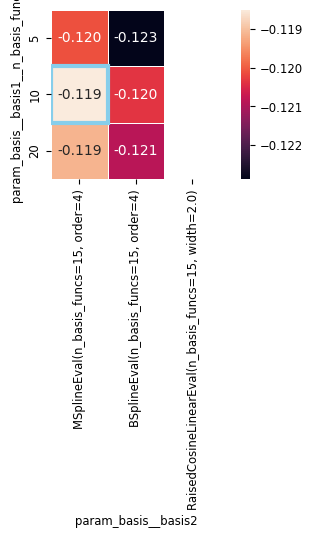

In [79]:
workshop_utils.plot_heatmap_cv_results(cv_df)

- Can easily grab the best estimator, the pipeline that did the best:

In [ ]:
best_estim = 

- Visualize model predictions!

In [75]:
visualize_model_predictions(best_estim, transformer_input)

NameError: name 'best_estim' is not defined

### Feature selection


- Now one more thing we can do with scikit-learn!
- Each `PopulationGLM` object has a feature mask, which allows us to exclude certain parts of the input
- Feature mask shape: `X.shape[1]` (number of columns in the design matrix) by `n_neurons` (number of neurons we're trying to predict)
- (By default, everything is included.)

In [ ]:
# enter code here

- We could manually edit feature mask, but have some helper functions -- these are currently being developed, so any feedback is appreciated!
- By default, we include all features:

In [ ]:
# enter code here

- Make use of our additive basis to figure out the structure in the input
- Can selectively remove some of the features:

In [ ]:
# enter code here

- Can construct a set of feature masks that includes / excludes each of the sets of inputs:

In [ ]:
# enter code here

- One more wrinkle: the shape of this feature mask depends on the number of basis functions!
- Thus, must create a new feature mask for each possible arrangement:

In [ ]:
param_grid = workshop_utils.create_feature_mask_paramgrid(basis, [5, 10, 20], 
                                                          [8, 16, 32], count.shape[1])

- Initialize and fit GridSearchCV

In [ ]:
# enter code here

- Investigate results using pandas

In [ ]:
# enter code here

- For our own sanity, let's create an easier-to-read label:

In [ ]:
def label_feature_mask(x):
    mask = x.param_glm__feature_mask
    if mask.sum() / np.prod(mask.shape) == 1:
        return "all"
    elif mask[0,0] == 1:
        return "position"
    else:
        return "speed"

cv_df['feature_mask_label'] = cv_df.apply(label_feature_mask, 1)

- And visualize:

In [ ]:
# enter code here

- What do we see?


- Visualize model predictions!

In [ ]:
visualize_model_predictions(cv.best_estimator_, transformer_input)

## Conclusion
## References



The data in this tutorial comes from [Grosmark, Andres D., and György Buzsáki. "Diversity in neural firing dynamics supports both rigid and learned hippocampal sequences." Science 351.6280 (2016): 1440-1443](https://www.science.org/doi/full/10.1126/science.aad1935).